# CML wet/dry detection

__CML data:__  
Imported from pycomlink (Chwala C:): https://github.com/pycomlink/pycomlink

__Sources: All code from [2]__  
github: https://github.com/jpolz/cml_wd_pytorch/tree/main  
thesis: https://doi.org/10.5194/amt-13-3835-2020

In [1]:
import modul.cnn as cnn
import pycomlink as pycml

import xarray as xr
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import sklearn.metrics as skl
import math
import itertools

In [2]:
from sklearn.utils import shuffle
from tqdm import tqdm
from IPython.display import clear_output

#### Load CML data
Import data of 500 CML links from pycomlink with 1min timestep

In [3]:
# 500 CMLs with 1 min time step
cml_set = xr.open_dataset('example_data/example_cml_data.nc', engine='netcdf4') # https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html

# Temporarily remove GPS coordinates - might add later with additional cml info for better CNN learning
# https://stackoverflow.com/questions/61003361/drop-coordinate-from-an-xarray-dataarray
cml_set = cml_set.reset_coords(['site_a_latitude','site_b_latitude','site_a_longitude','site_b_longitude'], drop=True)

#### Load Reference data
Reference rain rate data from RADOLAN. With 5 min step [mm/5 min]

In [4]:
# Path averaged reference RADOLAN data aligned with all 500 CML IDs with 5 min time step
ref_set = xr.open_dataset('example_data/example_path_averaged_reference_data.nc', engine='netcdf4')
ref_set = ref_set.rename_vars({'rainfall_amount':'rain'})
ref_set_copy = ref_set

## CML data preprocessing
1. replacing fault values
3. calculating TRSL
4. Interpolation  

pycomlink https://github.com/pycomlink/pycomlink/blob/master/notebooks/Basic%20CML%20processing%20workflow.ipynb

#### CML: Repair fault data and calculate TRSL

In [5]:
cml_set['tsl'] = cml_set.tsl.where(cml_set.tsl != 255.0)
cml_set['rsl'] = cml_set.rsl.where(cml_set.rsl != -99.9)
cml_set['trsl'] = cml_set.tsl - cml_set.rsl
cml_set['trsl'] = cml_set.trsl.interpolate_na(dim='time', method='linear', max_gap='5min')

cml_set = cml_set.transpose('cml_id', 'channel_id', 'time')

#### RADOLAN: Repair fault data, resample to 10 min, sum rain rate to mm/10min

In [6]:
ref_set['rain'] = ref_set.rain.interpolate_na(dim='time', method='linear', max_gap='20min')

# resample to intended sample size 10 min
ref_set = ref_set.resample(time="10min").sum()

ref_set = ref_set.transpose('cml_id', 'time')

#### Detect trsl gaps >5min and exclude cmls
TODO: in future, don't exclude cmls, mask gaps and exclude only missing data.  

Gap boolean signal is common for both cml channels. True if one or both have NaN

In [7]:
# get boolean flag for trsl missing values
cml_set['trsl_gap'] = (
        ('cml_id', 'time'), 
        np.logical_or(np.isnan(cml_set.trsl.isel(channel_id=0).values), np.isnan(cml_set.trsl.isel(channel_id=1).values))
)

In [8]:
# get cml ids with NaN gaps
has_gap = np.any(cml_set.trsl_gap.values, axis=1)
cmls_without_gap = np.where(~has_gap)[0]
num_correct_cmls = len(cmls_without_gap)

cml_set = cml_set.assign_coords({'has_gap':(('cml_id'), has_gap)})
ref_set = ref_set.assign_coords({'has_gap':(('cml_id'), has_gap)})

In [9]:
# optionally drop cmls with NaN gaps
if 1:
    cml_set = cml_set.where(~cml_set["has_gap"], drop=True)
    ref_set = ref_set.where(~ref_set["has_gap"], drop=True)

    # When vmls are dropped, bool variables turn into int, has to be turned back
    cml_set['trsl_gap'] = cml_set.trsl_gap.astype(bool)

#### Create reference bool W/D

In [10]:
# From reference rain rate derivate boolean reference Wet/Dry signal
ref_set['ref_wd'] = ref_set.rain.where(ref_set.rain == 0, True).astype(bool)

#### Plot one cml of dataset

Text(0.5, 1.0, '')

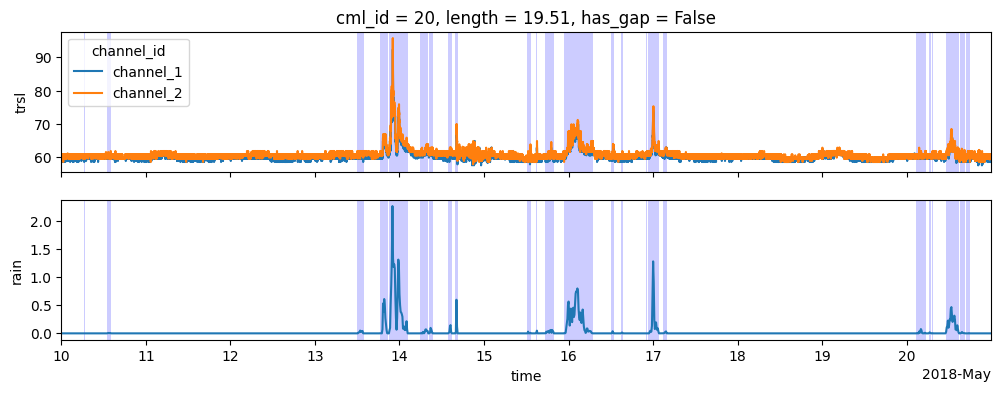

In [11]:
# select one cml:
cml_k = '20'
my_cml = cml_set.sel(cml_id = cml_k)        # .sel is not int indexing, but selecting specific 'label' 
my_ref = ref_set.sel(cml_id = cml_k)

# shaded refernece wet periods from Pycomlink
# set first and last value with zero for correct plotting
my_ref['ref_wd'][0] = False
#my_ref['ref_wd'][-1] = False

# setup figure
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12,4))
#ax1 = axs[0].twiny()
#fig.tight_layout()

# plot TRSL
my_cml.trsl.plot.line(x='time', ax=axs[0], label = 'TL');
# plot Rain rate 
my_ref.rain.plot.line(x='time', ax=axs[1], label = 'TL');

# plot real bool wet/dry with 5min precission
wet_start = np.roll(my_ref.ref_wd, -1) & ~my_ref.ref_wd
wet_end = np.roll(my_ref.ref_wd, 1) & ~my_ref.ref_wd
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    axs[1].axvspan(my_ref.time.values[wet_start_i], my_ref.ref_wd.time.values[wet_end_i], color='b', alpha=0.2, linewidth=0); # https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.axvspan.html
    axs[0].axvspan(my_ref.time.values[wet_start_i], my_ref.ref_wd.time.values[wet_end_i], color='b', alpha=0.2, linewidth=0); # https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.axvspan.html

# plot trsl gaps
my_cml['trsl_gap'][0] = False
my_cml['trsl_gap'][-1] = False

gap_start = np.roll(my_cml.trsl_gap, -1) & ~my_cml.trsl_gap
gap_end = np.roll(my_cml.trsl_gap, 1) & ~my_cml.trsl_gap
for gap_start_i, gap_end_i in zip(
    gap_start.values.nonzero()[0],
    gap_end.values.nonzero()[0],
):
    axs[0].axvspan(my_cml.time.values[gap_start_i], my_cml.time.values[gap_end_i], color='r', alpha=0.7, linewidth=0); # https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.axvspan.html
   

# axes limits source: https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_xlim.html
axs[1].set_xlim(my_cml.time.values[0], my_cml.time.values[-1])
axs[0].set_xlabel('')
axs[1].set_title("")


## Building dataset
1. creating dataset of training and reference data + data visualisation
2. Standardising

#### Align to a dataset with Reference RADOLAN data and calculate boolean Wet/dry Reference flag

#### Agregate 10min measurements into sample
To build samples for CNN. rain event will be predicted for whole sample
10 times 1 min time step = 10min time window   
source: chatGPT

__TODO: Possible simplification using .reshape or .view and rewriting trsl, ref_wd__

In [12]:
# extract metadata:
cml_id = cml_set.cml_id.values
length = cml_set.length.values
frequency = cml_set.frequency.values
polarization = cml_set.polarization.values


In [13]:
sample_size = 10 # = minutes
# get number of samples 
n_samples = len(cml_set.time) // sample_size 
# last few points cant make a sample of full length. Will be cut off.
cutoff = len(cml_set.time)-n_samples*sample_size
n_samples

1584

In [14]:
# Reshape dataset to a new shape with the sample_id dimension 
trsl_reshaped = cml_set['trsl'].values[:,:,:(n_samples*sample_size)].reshape(len(cml_set.cml_id),2, n_samples, sample_size)

# reshape and add vector of time into dataset to remember the time stamp
time_reshaped = cml_set['time'].values[:(n_samples*sample_size)].reshape(n_samples, sample_size)

In [15]:
# how many cmls include into dataset
num_cmls = 20

In [16]:
# Create a new xarray Dataset with sample_num as a dimension
# replace time and date with timestep in the time sample
ds = xr.Dataset({
    'trsl': (('cml_id', 'channel_id', 'sample_num', 'timestep'), trsl_reshaped[:num_cmls]),
    'rain': (('cml_id', 'sample_num'), ref_set['rain'].values[:num_cmls,:(n_samples*sample_size)]),
    'ref_wd': (('cml_id', 'sample_num'), ref_set['ref_wd'].values[:num_cmls,:(n_samples*sample_size)]),
    'time': (('sample_num', 'timestep'), time_reshaped)
}, coords={'cml_id': cml_id[:num_cmls],
           'channel_id': np.arange(2),
           'sample_num': np.arange(n_samples),
           'timestep': np.arange(sample_size),
           'length':(('cml_id'), length[:num_cmls]),                                  #single value is never a dimension
           'frequency': (('cml_id', 'channel_id'), frequency[:num_cmls]),          # this way coordinate will not become a dimension
           'polarization': (('cml_id', 'channel_id'), polarization[:num_cmls])
})

#### Plot dataset of the one chosen cml 

#### Standardising
"Subtracting the median of all available data from the preceding 72h from each time step."[2]   

Method: divide all trsl points with the median value for specified channell

In [17]:
# Calculate median and divide trsl for both channels

# Init. ds variable
if 'trsl_st' in ds:
    ds = ds.reset_coords(['trsl_st'], drop=True)    # if trsl_st exists, erase it. (issue fix)
ds['trsl_st'] = ds.trsl.copy()

# Standardising using median as minimum val
for i in range(num_cmls):
    ds['trsl_st'][i,0] = (ds.trsl[i,0] - ds.trsl[i,0].mean()) / (ds.trsl[i,0].max() - ds.trsl[i,0].mean())
    ds['trsl_st'][i,1] = (ds.trsl[i,1] - ds.trsl[i,1].mean()) / (ds.trsl[i,1].max() - ds.trsl[i,1].mean())

In [18]:
ds

<xarray.Dataset> Size: 11MB
Dimensions:       (cml_id: 20, channel_id: 2, sample_num: 1584, timestep: 10)
Coordinates:
  * cml_id        (cml_id) <U3 240B '0' '1' '2' '3' '4' ... '16' '17' '18' '20'
  * channel_id    (channel_id) int64 16B 0 1
  * sample_num    (sample_num) int64 13kB 0 1 2 3 4 ... 1579 1580 1581 1582 1583
  * timestep      (timestep) int64 80B 0 1 2 3 4 5 6 7 8 9
    length        (cml_id) float64 160B 6.179 5.673 7.52 ... 2.699 9.023 19.51
    frequency     (cml_id, channel_id) float64 320B 2.491e+10 ... 1.92e+10
    polarization  (cml_id, channel_id) <U1 160B 'V' 'V' 'H' 'H' ... 'V' 'V' 'V'
Data variables:
    trsl          (cml_id, channel_id, sample_num, timestep) float64 5MB 60.0...
    rain          (cml_id, sample_num) float64 253kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ref_wd        (cml_id, sample_num) bool 32kB False False ... False False
    time          (sample_num, timestep) datetime64[ns] 127kB 2018-05-10 ... ...
    trsl_st       (cml_id, channel_id, sample_num, timestep) float64 5MB 0.02...

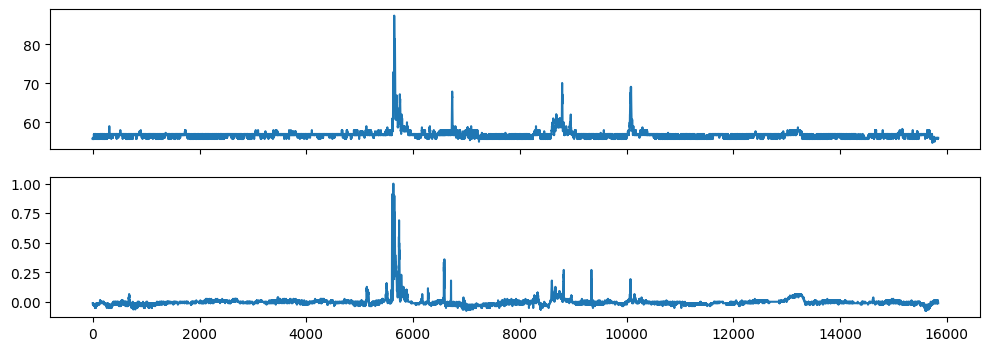

In [19]:
# check if the vertival range of standardized values is 0-1
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12,4))

axs[0].plot(ds.trsl.sel(cml_id='2').isel(channel_id=0).values.reshape(-1))
axs[1].plot(ds.trsl_st.sel(cml_id='4').isel(channel_id=0).values.reshape(-1))


#### Training/Testing data splitting + converting to tensors
<span style="color:red">TODO: </span>add validation data: 1 cml  
https://github.com/jpolz/cml_wd_pytorch/blob/main/wd_pytorch/train_cnn.ipynb [2]

In [20]:
# for tensors we need to make dataset 3D and make sample_num the first dimension
ds['trsl_st'] = ds.trsl_st.transpose('cml_id', 'sample_num', 'channel_id', 'timestep')

# remove sample id coordinate and reshape to 3D
trsl = ds.trsl_st.values.reshape(num_cmls*n_samples,2 , sample_size)
ref = ds.ref_wd.values.reshape(num_cmls*n_samples)

In [21]:
batchsize = 20
k_train = 0.8     # fraction of training data

train_size = int(len(trsl)*k_train/batchsize)* batchsize
train_size

25340

Shuffling data disabled, splitting and turning to arrays

In [22]:
train_data = trsl[:train_size]
test_data = trsl[train_size:]
train_ref = ref[:train_size]
test_ref = ref[train_size:]

Storing as tensors [2]

In [23]:
train_data = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)

train_ref = torch.Tensor(train_ref)
test_ref = torch.Tensor(test_ref)

Turning into dataset, shuffling

In [24]:
dataset = torch.utils.data.TensorDataset(train_data, train_ref)
testset = torch.utils.data.TensorDataset(test_data, test_ref)

trainloader = torch.utils.data.DataLoader(dataset, batch_size = batchsize, shuffle = False)    # shuffle the training data, once more? True
testloader = torch.utils.data.DataLoader(testset, batch_size = batchsize, shuffle = False)

## Training the CNN

In [25]:
model = cnn.cnn_class()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

# try lower training rate and no dropout


In [222]:
epochs = 20    # experimentally max epochs: 30, overfitting around 15
resume = 5     # continue learning at epoch xx 
# Low epochs make cnn output low? around 0.5 max

In [223]:
if resume == 0:
    loss_dict = {}
    loss_dict['train'] = {}
    loss_dict['test'] = {}
    for key in ['train','test']:
        loss_dict[key]['loss'] = []

19

train loss: 0.20691852
test loss: 0.20381825
min test loss: 0.20137946


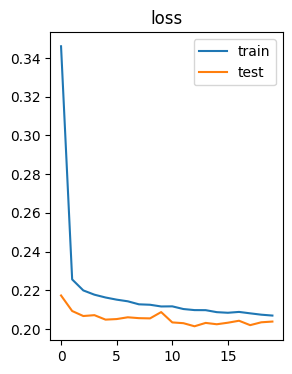

In [224]:
for epoch in range(resume, epochs):
    # training
    cnn_prediction = []
    train_losses = []
    for inputs, targets in tqdm(trainloader):
        optimizer.zero_grad()
        pred = model(inputs)
        pred = nn.Flatten(0,1)(pred)            # transpose column data into row
       
        # getting the output
        if epoch == epochs-1: cnn_prediction = cnn_prediction+pred.tolist()
        
        # calculating the loss function        
        loss = nn.BCELoss()(pred, targets)      # Targets and Imputs size must match
        loss.backward()
        optimizer.step()
        train_losses.append(loss.detach().numpy())
    loss_dict['train']['loss'].append(np.mean(train_losses))

    
    # testing
    test_losses = []
    with torch.no_grad():
        for inputs, targets in tqdm(testloader):
            pred = model(inputs)
            # pred = pred.round()
            pred = nn.Flatten(0,1)(pred)
            
            # getting the output
            if epoch == epochs-1: cnn_prediction = cnn_prediction+pred.tolist()
                
            loss = nn.BCELoss()(pred, targets)
            test_losses.append(loss.detach().numpy())
        loss_dict['test']['loss'].append(np.mean(test_losses))
        
    # printing
    clear_output(wait=True)
    print(epoch)
    print('')
    print('train loss:', np.mean(train_losses))
    print('test loss:', np.mean(test_losses))
    print('min test loss:', np.min(loss_dict['test']['loss']))
    fig, axs = plt.subplots(1,1, figsize=(3,4))
    for key in loss_dict.keys():
        for k, key2 in enumerate(loss_dict[key].keys()):
            axs.plot(loss_dict[key][key2], label=key)
            axs.set_title(key2)
    # axs.set_yscale('log')
    plt.legend()
    plt.show()
    resume = epoch

## Data validation
prediction output, confusion matrix, MCC...
#### Plot the prediction output
#### <span style="color:red">TODO: </span>Add Legends to figures

In [225]:
ds['cnn_out'] = (('cml_id', 'sample_num'), np.array(cnn_prediction).reshape(num_cmls,-1))

In [226]:
cnn_wd_threshold = 0.5

ds['cnn_wd'] = (('cml_id', 'sample_num'), ds.cnn_out.values > cnn_wd_threshold)

In [227]:
# predicted true wet
ds['true_wet'] = ds.cnn_wd & ds.ref_wd 
# cnn false alarm
ds['false_alarm'] = ds.cnn_wd & ~ds.ref_wd
# cnn missed wet
ds['missed_wet'] = ~ds.cnn_wd & ds.ref_wd

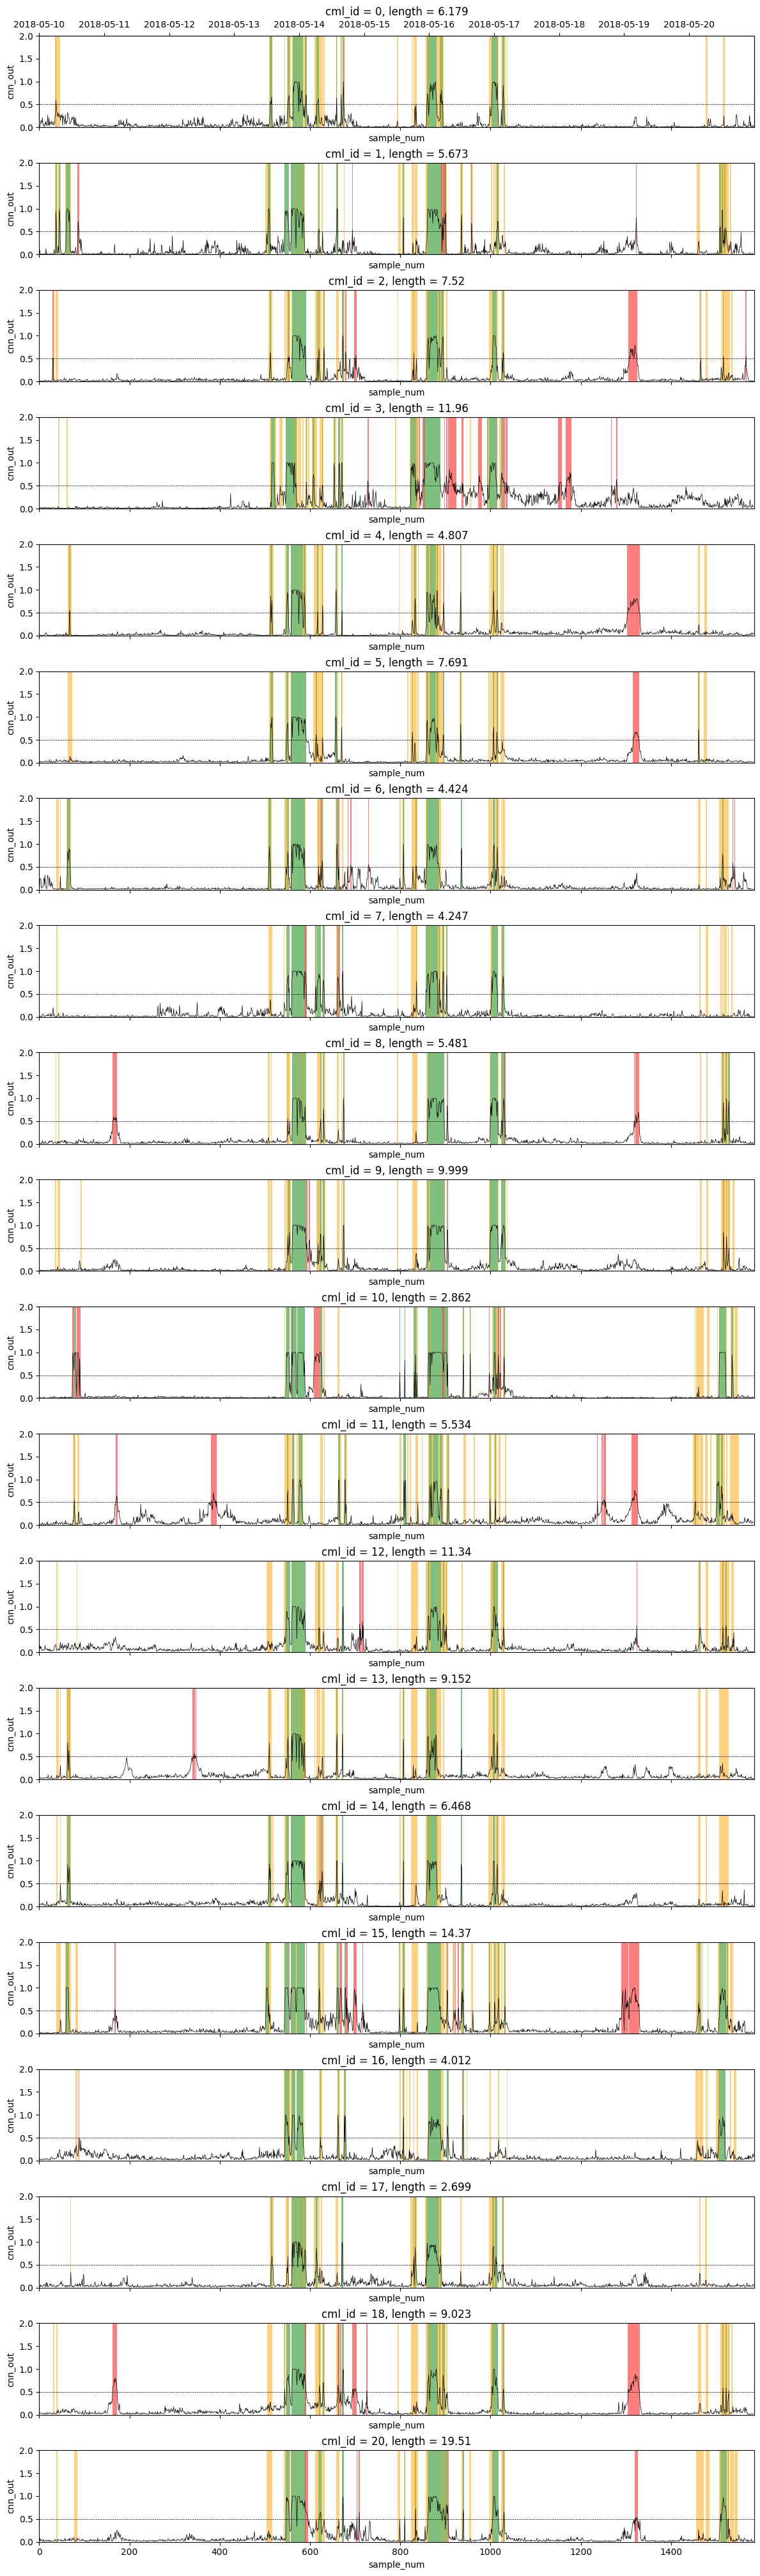

In [228]:
# setup figure
fig, axs = plt.subplots(num_cmls, 1, sharex=True, figsize=(12,num_cmls*2))
ax1 = axs[0].twiny()
ax1.set_xlim(ds.time.values[0,0], ds.time.values[-1,-1])
fig.tight_layout(h_pad = 3)

for n in range(num_cmls):    
    axs[n].set_xlim(0, n_samples + cutoff)
    axs[n].set_ylim(0,2);    
    # plot cnn prediction
    ds.cnn_out[n].plot.line(x='sample_num', ax=axs[n], label = 'TL',color='black', lw=0.5);

    #cnn threshold
    axs[n].axhline(cnn_wd_threshold, color='black', linestyle='--', lw=0.5)

    # GREEN: plot true cnn predicted wet/dry areas
    # tip from stack ovefrolw: https://stackoverflow.com/questions/44632903/setting-multiple-axvspan-labels-as-one-element-in-legend
    start = np.roll(ds.true_wet[n], -1) & ~ds.true_wet[n]
    end = np.roll(ds.true_wet[n], 1) & ~ds.true_wet[n]
    for start_i, end_i in zip(
        start.values.nonzero()[0],
        end.values.nonzero()[0],
    ):
        axs[n].axvspan(ds.sample_num.values[start_i], ds.sample_num.values[end_i], color='g', alpha=0.5, linewidth=0, label='_'*start_i+'true wet') 
    
    # RED: plot false alarms
    start = np.roll(ds.false_alarm[n], -1) & ~ds.false_alarm[n]
    end = np.roll(ds.false_alarm[n], 1) & ~ds.false_alarm[n]
    for start_i, end_i in zip(
        start.values.nonzero()[0],
        end.values.nonzero()[0],
    ):
        axs[n].axvspan(ds.sample_num.values[start_i], ds.sample_num.values[end_i], color='r', alpha=0.5, linewidth=0, label='_'*start_i+'false alarm') 
        
    # ORANGE: plot missed wet 
    start = np.roll(ds.missed_wet[n], -1) & ~ds.missed_wet[n]
    end = np.roll(ds.missed_wet[n], 1) & ~ds.missed_wet[n]
    for start_i, end_i in zip(
        start.values.nonzero()[0],
        end.values.nonzero()[0],
    ):
        axs[n].axvspan(ds.sample_num.values[start_i], ds.sample_num.values[end_i], color='orange', alpha=0.5, linewidth=0, label='_'*start_i+'missed wet')






#### ROC curve ... calculated for whole testing dataset

source: [2], https://github.com/jpolz/cnn_cml_wet-dry_example/blob/master/CNN_for_CML_example_nb.ipynb  

#### <span style="color:red">TODO:</span> Add ROC and CM for all testing, all training, one best and one worst

In [283]:
def roc_curve(y_pred, y_true, tr_start, tr_end):
    '''
    Compute the ROC curve for the CNN. The minimum threshold is tr_start and the maximum threshold is tr_end.
    '''
    roc = []
    for i in range(tr_start*1000,1+tr_end*1000,1):
        t = i/1000
        y_predicted=np.ravel(y_pred>t)  
        true_pos = np.sum(np.logical_and(y_true==1, y_predicted==1))
        true_neg = np.sum(np.logical_and(y_true==0, y_predicted==0))
        false_pos = np.sum(np.logical_and(y_true==0, y_predicted==1))
        false_neg = np.sum(np.logical_and(y_true==1, y_predicted==0))
        cond_neg = true_neg+false_pos
        cond_pos = true_pos+false_neg
        roc.append([true_pos/cond_pos,
                    false_pos/cond_neg])
    roc.append([0,0])
    
    return np.array(roc)

def roc_surface(roc):
    '''
    Compute the Area under a ROC curve.
    '''
    k = len(roc)
    surf=0
    for i in range(k-1):
        surf= surf+(np.abs(roc[i,1]-roc[i+1,1]))*0.5*(roc[i+1,0]+roc[i,0])
    
    return surf

In [230]:
# select testing cmls
first_test_cml_id = int(math.ceil(k_train * num_cmls))

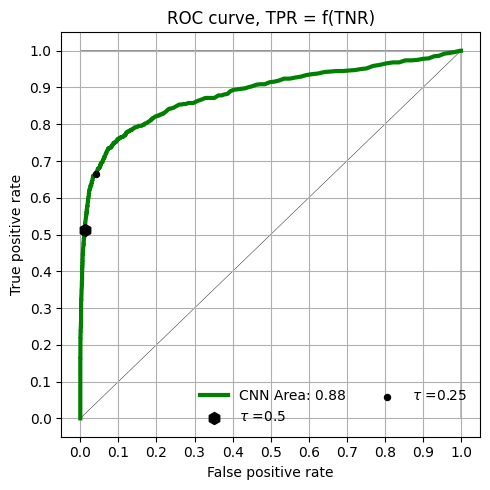

In [268]:
# ROC curve
roc = roc_curve(ds.cnn_out[first_test_cml_id:].values.reshape(-1), ds.ref_wd[first_test_cml_id:].values.reshape(-1), 0, 1)

plt.figure(figsize=(5,5))
plt.plot(roc[:,1],roc[:,0], color='green', label='CNN Area: '+str(np.round(roc_surface(roc), decimals=2)), zorder=2, lw=3)

# plot point of cnn threshold for optimalisation
plt.scatter(roc[int(cnn_wd_threshold*1000),1],roc[int(cnn_wd_threshold*1000),0], color='black', marker='h', s=75, label='$\\tau$ ='+str(cnn_wd_threshold), zorder=3)
thr = 0.25
plt.scatter(roc[int(thr*1000),1],roc[int(thr*1000),0], color='black', marker='.', s=75, label='$\\tau$ ='+str(thr), zorder=3)

plt.plot([0,0,1,0,1,1],[0,1,1,0,0,1], 'k-', linewidth=0.3, zorder=1)
plt.title('ROC curve, TPR = f(TNR)')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right', ncol=2, frameon=False)
plt.grid()
plt.yticks(np.arange(0, 1.01, 0.1))
plt.xticks(np.arange(0, 1.01, 0.1))
plt.tight_layout()
plt.show()

#### MCC, ACC, confusion matrix ... calculated for whole testing dataset
source: [2], https://github.com/jpolz/cnn_cml_wet-dry_example/blob/master/CNN_for_CML_example_nb.ipynb

In [232]:
print('CNN scores')

# confusion matrix 
cm = skl.confusion_matrix(ds.ref_wd[first_test_cml_id:].values.reshape(-1), ds.cnn_wd[first_test_cml_id:].values.reshape(-1), labels=[0,1], normalize='true').round(decimals=2)
print('normalized confusion matrix:\n',cm)
print('TNR:', cm[0,0])
print('TPR:', cm[1,1])

# Matthews Correlation Coeficient
mcc = skl.matthews_corrcoef(ds.ref_wd[first_test_cml_id:].values.reshape(-1), ds.cnn_wd[first_test_cml_id:].values.reshape(-1)).round(decimals=2)
print('MCC:', mcc)

# 
acc = np.round(skl.accuracy_score(ds.ref_wd[first_test_cml_id:].values.reshape(-1), ds.cnn_wd[first_test_cml_id:].values.reshape(-1)), decimals=2)
print('ACC:', acc)

f1 = skl.f1_score(ds.ref_wd[first_test_cml_id:].values.reshape(-1), ds.cnn_wd[first_test_cml_id:].values.reshape(-1)).round(decimals=2)
print('F1:', f1)

# ROC curve surface
a = roc_surface(roc).round(decimals=2)
print('ROC surface A:', a)

CNN scores
normalized confusion matrix:
 [[0.99 0.01]
 [0.49 0.51]]
TNR: 0.99
TPR: 0.51
MCC: 0.63
ACC: 0.93
F1: 0.64
ROC surface A: 0.88


C:\Users\lukas\AppData\Local\Temp\ipykernel_6496\4195543879.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([''] + labels)
C:\Users\lukas\AppData\Local\Temp\ipykernel_6496\4195543879.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([''] + labels)


Text(0.5, 1.0, 'CNN')

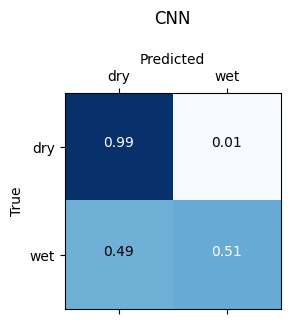

In [233]:

# plot the confusion matrix
labels = ['dry', 'wet']

fig, ax1 = plt.subplots(figsize=(3,3), sharex=True)
#ax1 = fig.add_subplot(131)

cax = ax1.matshow(cm, cmap=plt.cm.Blues)
ax1.set_xticklabels([''] + labels)
ax1.set_yticklabels([''] + labels)
fmt = '.2f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black"
)
    
plt.xlabel('Predicted')
plt.ylabel('True')
ax1.xaxis.set_label_position('top') 
plt.tight_layout()
plt.title('CNN', pad=50)

#### old: Metrics for one cml

In [238]:
cml_k = '16'

In [284]:
# Calculate ROC curve for all training + testing cmls
roc_c = np.empty([num_cmls, 1002,2])
roc_surface = np.empty([num_cmls])

for i in range(num_cmls):
    roc_c[i] = roc_curve(ds.cnn_out[i], ds.ref_wd[i], 0, 1)
    roc_surface[i] = np.round(roc_surface(roc_curve[i]), decimals=2)


TypeError: 'function' object is not subscriptable

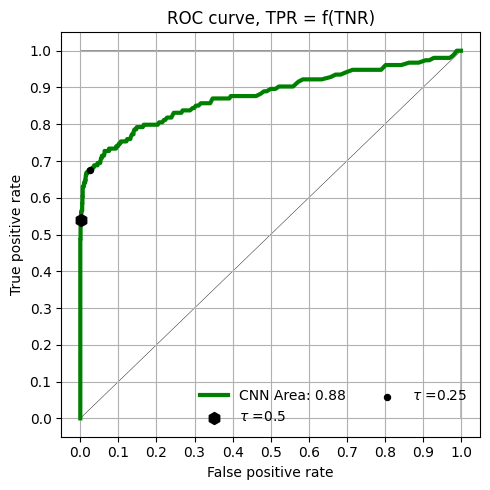

In [239]:



plt.figure(figsize=(5,5))
plt.plot(roc[:,1],roc[:,0], color='green', label='CNN Area: '+str(np.round(roc_surface(roc), decimals=2)), zorder=2, lw=3)

# plot point of cnn threshold for optimalisation
plt.scatter(roc[int(cnn_wd_threshold*1000),1],roc[int(cnn_wd_threshold*1000),0], color='black', marker='h', s=75, label='$\\tau$ ='+str(cnn_wd_threshold), zorder=3)
thr = 0.25
plt.scatter(roc[int(thr*1000),1],roc[int(thr*1000),0], color='black', marker='.', s=75, label='$\\tau$ ='+str(thr), zorder=3)

plt.plot([0,0,1,0,1,1],[0,1,1,0,0,1], 'k-', linewidth=0.3, zorder=1)
plt.title('ROC curve, TPR = f(TNR)')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right', ncol=2, frameon=False)
plt.grid()
plt.yticks(np.arange(0, 1.01, 0.1))
plt.xticks(np.arange(0, 1.01, 0.1))
plt.tight_layout()
plt.show()

In [240]:
print('CNN scores')

# confusion matrix 
cm = skl.confusion_matrix(ds.ref_wd.sel(cml_id=cml_k), ds.cnn_wd.sel(cml_id=cml_k), labels=[0,1], normalize='true').round(decimals=2)
print('normalized confusion matrix:\n',cm)

print('confusion matrix:\n',skl.confusion_matrix(ds.ref_wd.sel(cml_id=cml_k), ds.cnn_wd.sel(cml_id=cml_k)).round(decimals=2))
print('TNR:', cm[0,0])
print('TPR:', cm[1,1])

# Matthews Correlation Coeficient
mcc = skl.matthews_corrcoef(ds.ref_wd.sel(cml_id=cml_k), ds.cnn_wd.sel(cml_id=cml_k)).round(decimals=2)
print('MCC:', mcc)

# 
acc = np.round(skl.accuracy_score(ds.ref_wd.sel(cml_id=cml_k), ds.cnn_wd.sel(cml_id=cml_k)), decimals=2)
print('ACC:', acc)

f1 = skl.f1_score(ds.ref_wd.sel(cml_id=cml_k), ds.cnn_wd.sel(cml_id=cml_k)).round(decimals=2)
print('F1:', f1)

# ROC curve surface
a = roc_surface(roc).round(decimals=2)
print('ROC surface A:', a)

CNN scores
normalized confusion matrix:
 [[1.   0.  ]
 [0.46 0.54]]
confusion matrix:
 [[1428    2]
 [  71   83]]
TNR: 1.0
TPR: 0.54
MCC: 0.71
ACC: 0.95
F1: 0.69
ROC surface A: 0.88


C:\Users\lukas\AppData\Local\Temp\ipykernel_6496\2692937526.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([''] + labels)
C:\Users\lukas\AppData\Local\Temp\ipykernel_6496\2692937526.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([''] + labels)


Text(0.5, 1.0, 'CNN')

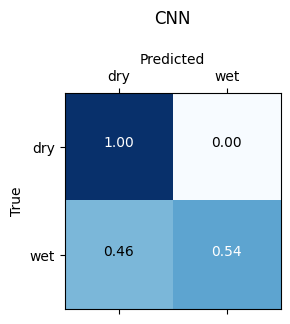

In [241]:
# plot the confusion matrix
labels = ['dry', 'wet']

fig, ax1 = plt.subplots(figsize=(3,3), sharex=True)
#ax1 = fig.add_subplot(131)

cax = ax1.matshow(cm, cmap=plt.cm.Blues)
ax1.set_xticklabels([''] + labels)
ax1.set_yticklabels([''] + labels)
fmt = '.2f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black"
)
    
plt.xlabel('Predicted')
plt.ylabel('True')
ax1.xaxis.set_label_position('top') 
plt.tight_layout()
plt.title('CNN', pad=50)

# Wet Antenna Attenuation
For CNN predicted wet/dry periods.  
Using modules imported from Pycomlink and code based on Pycomlink Tutorials

#### Reshape dataset back to time domain
<span style="color:red">Assuming, each reference RADOLAN rain sample taken in time TT is measurement from <TT; TT + 5min> period. </span> This assumption may itroduce up to 5min time shift between reference and CML data (TT measurement contains rather value from <TT-5min; TT>), but doesn't introduce any invasive change to the original data.  
In future RADOLAN ref values may be shifted -5 minutes in preprocessing.

Please note that:

- The wet-dry classification, which is done is a very simple way here, also plays a significant role for rain rates estimation.
- For a different CMLs, different WAA methods and different parameters might perform best.
- The radar rainfall reference cannot not be trusted 100% at its 5-minute resolution since the gauge-adjustment is done on hourly basis and then applied to the 5-min data. In addition, the radar reference might have larger uncertainty in regions far away from the gauges that have been used for the hourly adjustment. We have not included this info in our RADKLIM-YW dataset, hence, we have to treat the radar_along_cml equally for all CMLs. But, differences between CML and radar reference do not always mean the CML is wrong.

Below you can change the CML that is chosen and also play with different WAA parameters. You will find that there is no optimal solution for all CMLs, and that the wet-dry classification has a strong impact on the overall CML rainfall sum.

In [242]:
# Reshape dataset back to time domain
trsl_waa = ds.trsl.values.reshape(num_cmls,2,-1)
cnn_waa = np.repeat(ds.cnn_wd.values.reshape(num_cmls,-1),10, axis=1)   # cnn_wd output upsampled to 1min by repeating the values 
time_waa = ds.time.values.reshape(-1)                  # to be dimension again

In [243]:
# Create a new xarray Dataset in time domain
# cnn_wd upsampled 10 times
ds_waa = xr.Dataset({
    'trsl': (('cml_id','channel_id', 'time'), trsl_waa),
    'cnn_wd': (('cml_id','time'), cnn_waa) #,    'R_ref': (('cml_id','time'), R_ref_waa)
}, coords={'cml_id': cml_id[:num_cmls],
           'channel_id': np.arange(2),
           'time': time_waa,
           'length':(('cml_id'), length[:num_cmls]),                                  #single value is never a dimension
           'frequency': (('cml_id', 'channel_id'), frequency[:num_cmls]),          # this way coordinate will not become a dimension
           'polarization': (('cml_id', 'channel_id'), polarization[:num_cmls])
})

#### CML baseline for CNN predicted Wet signal calculated with Pycomlink modul

In [255]:
cml_k = '1'

In [256]:
ds_waa['baseline'] = pycml.processing.baseline.baseline_constant(
        trsl=ds_waa.trsl,
        wet=ds_waa.cnn_wd,
        n_average_last_dry=10
)

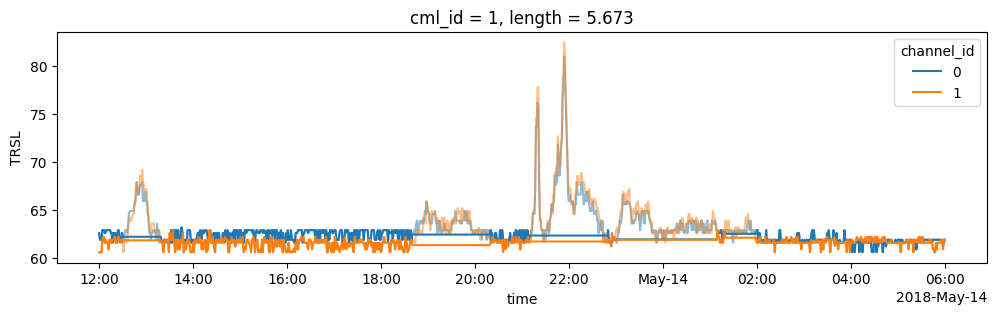

In [257]:
fig, ax = plt.subplots(figsize=(12,3))

ds_waa.trsl.sel(cml_id=cml_k, time=slice('2018-05-13T12:00', '2018-05-14T06:00')).plot.line(x='time', alpha=0.5)
plt.gca().set_prop_cycle(None)  # reuse plot colors
ds_waa.baseline.sel(cml_id=cml_k, time=slice('2018-05-13T12:00', '2018-05-14T06:00')).plot.line(x='time');
plt.ylabel('TRSL');

#### Wet antenna attenuation estimation
from Pycomlink using Schleiss, Leijnse and Pastorek mathematical models

1) Rain rate without WAA comp
#### <span style="color:red">TODO: </span> Rain rate calculated from both Channels separatelly, Choose one or average

In [258]:
# Rain induced attenuation
ds_waa['A_rain'] = ds_waa.trsl - ds_waa.baseline
ds_waa['A_rain'].values[ds_waa.A_rain < 0] = 0

# calculate R using k-R relation without WAA comp.
ds_waa['R'] = pycml.processing.k_R_relation.calc_R_from_A(
        A=ds_waa.A_rain, 
        L_km=ds_waa.length, 
        f_GHz=ds_waa.frequency/1e9, 
        pol=ds_waa.polarization
)

2) WAA Schleiss, Leijnse and Pastorek

In [259]:
ds_waa['waa_schleiss'] = pycml.processing.wet_antenna.waa_schleiss_2013(
    rsl=ds_waa.trsl, 
    baseline=ds_waa.baseline, 
    wet=ds_waa.cnn_wd, 
    waa_max=2.2, 
    delta_t=1, 
    tau=15,
)

ds_waa['waa_leijnse'] = pycml.processing.wet_antenna.waa_leijnse_2008_from_A_obs(
    A_obs=ds_waa.A_rain,
    f_Hz=ds_waa.frequency,
    pol=ds_waa.polarization,
    L_km=ds_waa.length,
)

ds_waa['waa_pastorek'] = pycml.processing.wet_antenna.waa_pastorek_2021_from_A_obs(
    A_obs=ds_waa.A_rain,
    f_Hz=ds_waa.frequency,
    pol=ds_waa.polarization,
    L_km=ds_waa.length,
    A_max=2.2,
)

3. Rain induced ATT and rain rate using k-R relation. For all 3 WAA compensation methods

In [260]:
# R for all 3 WAA methods
for waa_method in ['leijnse', 'pastorek', 'schleiss']:
    ds_waa[f'A_rain_{waa_method}'] = ds_waa.A_rain - ds_waa[f'waa_{waa_method}']
    ds_waa[f'A_rain_{waa_method}'] = ds_waa[f'A_rain_{waa_method}'].where(ds_waa[f'A_rain_{waa_method}'] >= 0, 0)    
    
    ds_waa[f'R_{waa_method}'] = pycml.processing.k_R_relation.calc_R_from_A(
        A=ds_waa[f'A_rain_{waa_method}'], 
        L_km=ds_waa.length, 
        f_GHz=ds_waa.frequency/1e9, 
        pol=ds_waa.polarization
    )


####  Predicted Rainrates in time domain + Cumulative sum

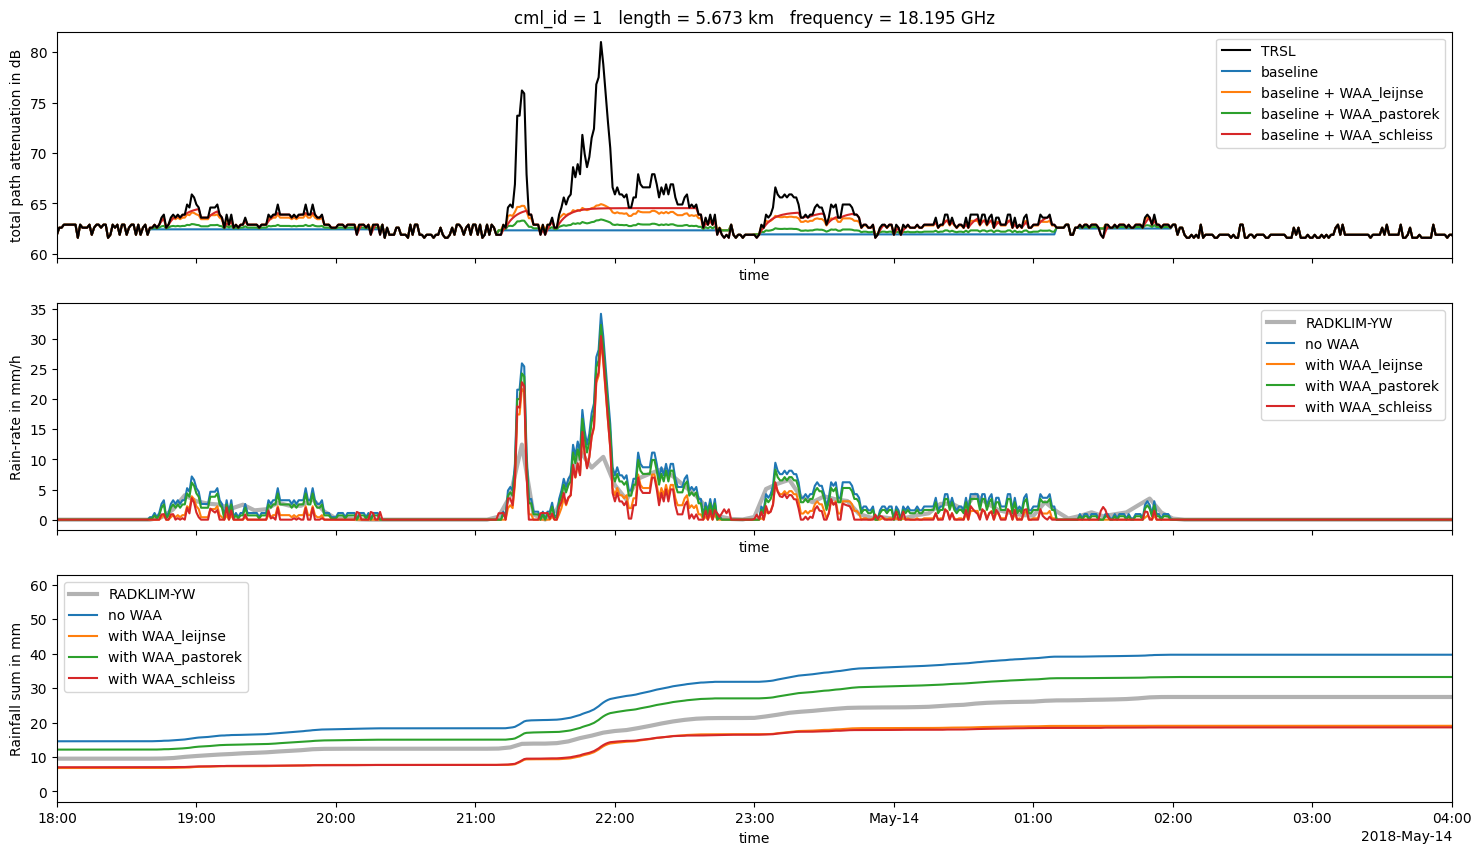

In [261]:
# note: 
#     Reference 1h rainfall rate sampled to 5 min has to be converted to 5min rain rate ... multiplied by 60/5 min
#     CML rain rate will be resampled to 5 min 

# TRSL + rain induced attenuation
fig, axs = plt.subplots(3, 1, figsize=(18, 10), sharex=True)
plt.sca(axs[0])
ds_waa.trsl.sel(cml_id=cml_k).isel(channel_id=0).plot.line(x='time', label='TRSL', color='k', zorder=10)
ds_waa.baseline.sel(cml_id=cml_k).isel(channel_id=0).plot.line(x='time', label='baseline', color='C0')
(ds_waa.baseline + ds_waa.waa_leijnse).sel(cml_id=cml_k).isel(channel_id=0).plot.line(x='time', label='baseline + WAA_leijnse', color='C1')
(ds_waa.baseline + ds_waa.waa_pastorek).sel(cml_id=cml_k).isel(channel_id=0).plot.line(x='time', label='baseline + WAA_pastorek', color='C2')
(ds_waa.baseline + ds_waa.waa_schleiss).sel(cml_id=cml_k).isel(channel_id=0).plot.line(x='time', label='baseline + WAA_schleiss', color='C3')
plt.ylabel('total path attenuation in dB')
plt.title(f'cml_id = {ds_waa.cml_id.sel(cml_id=cml_k).values}   length = {ds_waa.length.sel(
    cml_id=cml_k).values.round(decimals=3) } km   frequency = {ds_waa.frequency.sel(cml_id=cml_k).isel(channel_id=0).values/1e9} GHz')
plt.legend()

# Reference RADOLAN rainrate with 
plt.sca(axs[1])
(ref_set_copy.sel(cml_id=cml_k).rain * 12).plot.line(color='k', linewidth=3.0, label='RADKLIM-YW', alpha=0.3)
ds_waa.R.sel(cml_id=cml_k).isel(channel_id=0).plot.line(x='time', label='no WAA', color='C0')
ds_waa.R_leijnse.sel(cml_id=cml_k).isel(channel_id=0).plot.line(x='time', label='with WAA_leijnse', color='C1')
ds_waa.R_pastorek.sel(cml_id=cml_k).isel(channel_id=0).plot.line(x='time', label='with WAA_pastorek', color='C2')
ds_waa.R_schleiss.sel(cml_id=cml_k).isel(channel_id=0).plot.line(x='time', label='with WAA_schleiss', color='C3')
plt.ylabel('Rain-rate in mm/h')
plt.title('')
plt.legend()

plt.sca(axs[2])
ref_set_copy.sel(cml_id=cml_k).rain.cumsum(dim='time').plot.line(color='k', linewidth=3.0, label='RADKLIM-YW', alpha=0.3)
(ds_waa.R.sel(cml_id=cml_k).isel(channel_id=0)/60).cumsum(dim='time').plot.line(x='time', label='no WAA', color='C0')
(ds_waa.R_leijnse.sel(cml_id=cml_k).isel(channel_id=0)/60).cumsum(dim='time').plot.line(x='time', label='with WAA_leijnse', color='C1')
(ds_waa.R_pastorek.sel(cml_id=cml_k).isel(channel_id=0)/60).cumsum(dim='time').plot.line(x='time', label='with WAA_pastorek', color='C2')
(ds_waa.R_schleiss.sel(cml_id=cml_k).isel(channel_id=0)/60).cumsum(dim='time').plot.line(x='time', label='with WAA_schleiss', color='C3')
plt.ylabel('Rainfall sum in mm')
plt.title('')
plt.legend();

axs[1].set_xlim(pd.to_datetime('2018-05-13T18:00'), pd.to_datetime('2018-05-14T04:00'));

#### Rainrate XY scatterplot
CML predicted Rainrate vs real Rainrate. Shows spread on different Rainrates

In [262]:
def hexbinplot(R_radar_along_cml, R_cml, ax, color='k', title=None, loglog=True):
    R_cml = R_cml.isel(channel_id=0).resample(time='5min').mean().reindex_like(R_radar_along_cml, method=None)
    R_cml.values[R_cml.values < 0] = 0
    #R_cml = R_cml.resample(time='1h').mean()
    #R_radar_along_cml = R_radar_along_cml.resample(time='1h').mean()
    ax.scatter(
        R_radar_along_cml.where(R_radar_along_cml > 0).values,
        R_cml.where(R_cml > 0).values,
        c=color,
        s=10,
        alpha=0.7,
    )
    if loglog:
        ax.set_xscale('log')
        ax.set_yscale('log')
    ax.set_title(title)
    ax.set_xlabel('Average radar rain rate along CML in mm/h')
    ax.set_ylabel('CML rain rates in mm/h')


In [263]:
ref_R = ref_set_copy.sel(cml_id=cml_k).rain * 12
ds_hex = ds_waa.sel(cml_id=cml_k)

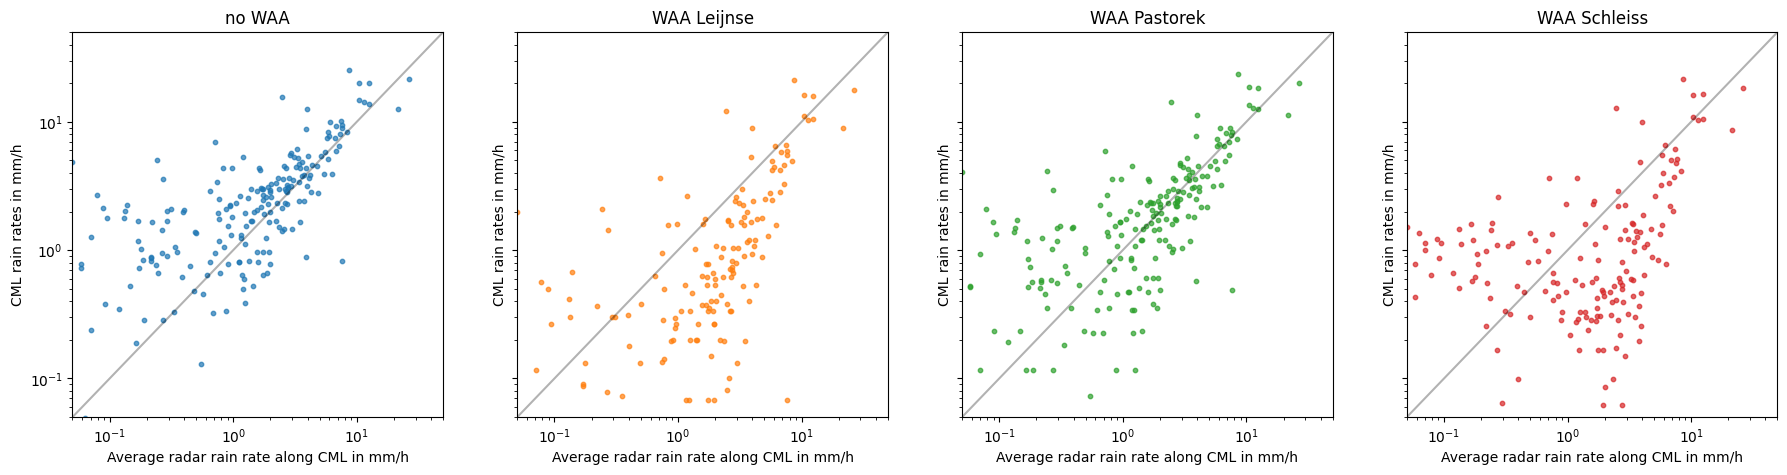

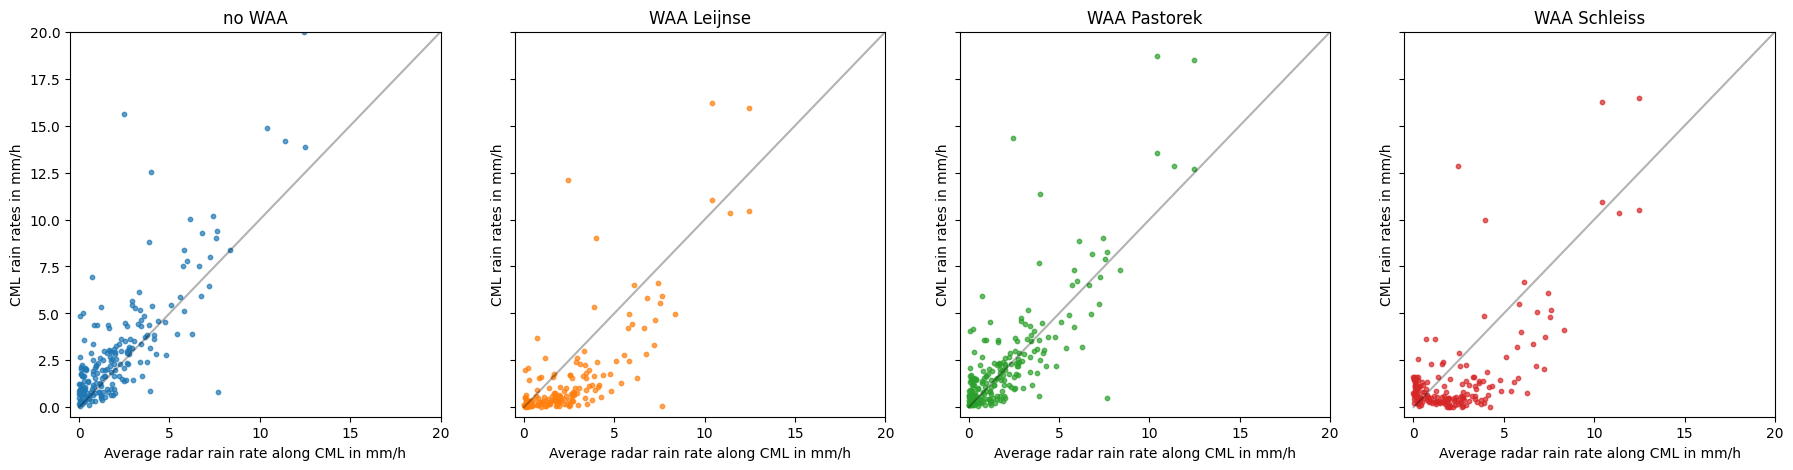

In [264]:
fig, axs = plt.subplots(1, 4, figsize=(22, 5), sharex=True, sharey=True)

hexbinplot(ref_R, ds_hex.R, axs[0], 'C0', 'no WAA')
hexbinplot(ref_R, ds_hex.R_leijnse, axs[1], 'C1', 'WAA Leijnse')
hexbinplot(ref_R, ds_hex.R_pastorek, axs[2], 'C2', 'WAA Pastorek')
hexbinplot(ref_R, ds_hex.R_schleiss, axs[3], 'C3', 'WAA Schleiss')

for ax in axs:
    ax.plot([0.01, 50], [0.01, 50], 'k', alpha=0.3)
    ax.set_xlim(0.05, 50)
    ax.set_ylim(0.05, 50)

fig, axs = plt.subplots(1, 4, figsize=(22, 5), sharex=True, sharey=True)

loglog=False
hexbinplot(ref_R, ds_hex.R, axs[0], 'C0', 'no WAA', loglog=loglog)
hexbinplot(ref_R, ds_hex.R_leijnse, axs[1], 'C1', 'WAA Leijnse', loglog=loglog)
hexbinplot(ref_R, ds_hex.R_pastorek, axs[2], 'C2', 'WAA Pastorek', loglog=loglog)
hexbinplot(ref_R, ds_hex.R_schleiss, axs[3], 'C3', 'WAA Schleiss', loglog=loglog)

for ax in axs:
    ax.plot([0.01, 50], [0.01, 50], 'k', alpha=0.3)
    ax.set_xlim(-0.5, 20)
    ax.set_ylim(-0.5, 20)

#### 5min rainrate dependent Rain accumulation 
Shows deviation of WAA comp. methods from real Rainrate

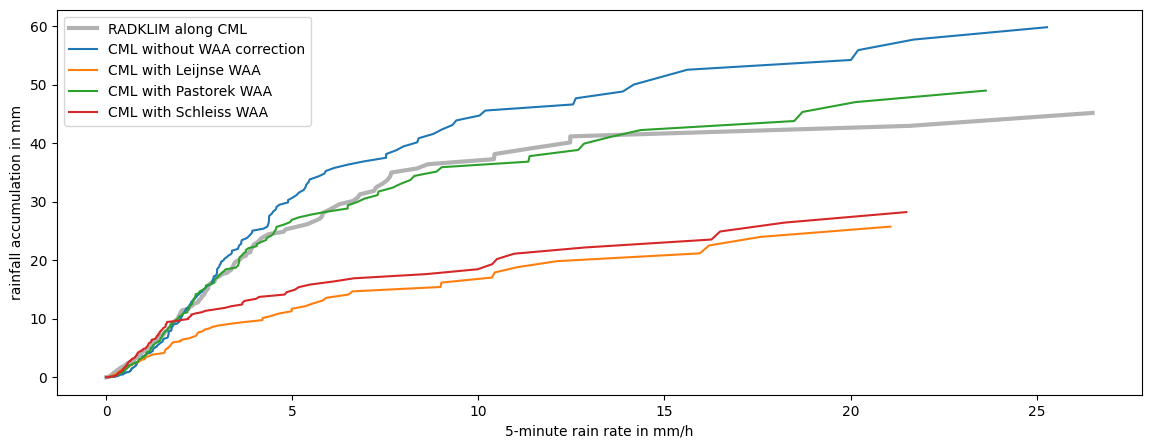

In [265]:
fig, ax = plt.subplots(figsize=(14, 5))
plt.plot(np.sort(ref_R.values), np.sort(ref_R.values / 12).cumsum(), label='RADKLIM along CML', color='k', alpha=0.3, linewidth=3)

R_cml = ds_hex.R.isel(channel_id=0).resample(time='5min').mean().reindex_like(ref_R, method=None)
plt.plot(np.sort(R_cml.values), np.sort(R_cml.values / 12).cumsum(), label='CML without WAA correction')

R_cml = ds_hex.R_leijnse.isel(channel_id=0).resample(time='5min').mean().reindex_like(ref_R, method=None)
plt.plot(np.sort(R_cml.values), np.sort(R_cml.values / 12).cumsum(), label='CML with Leijnse WAA')

R_cml = ds_hex.R_pastorek.isel(channel_id=0).resample(time='5min').mean().reindex_like(ref_R, method=None)
plt.plot(np.sort(R_cml.values), np.sort(R_cml.values / 12).cumsum(), label='CML with Pastorek WAA')

R_cml = ds_hex.R_schleiss.isel(channel_id=0).resample(time='5min').mean().reindex_like(ref_R, method=None)
plt.plot(np.sort(R_cml.values), np.sort(R_cml.values / 12).cumsum(), label='CML with Schleiss WAA')

plt.xlabel('5-minute rain rate in mm/h')
plt.ylabel('rainfall accumulation in mm')
plt.legend();
#plt.xscale('log')
#plt.xlim(0.1, 50)

### ____________________________________________________________________________________________________________

### rolling standard deviation classification for reference

In [ ]:
threshold = 0.8

roll_std_dev = my_cml.trsl.rolling(time=60, center=True).std()
my_cml['rsd_wet'] = my_cml.trsl.rolling(time=60, center=True).std() > threshold

In [ ]:
my_cml

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(12,5), sharex=True)

roll_std_dev.plot.line(x='time', ax=axs[0])
axs[0].axhline(threshold, color='k', linestyle='--')

my_cml.trsl.plot.line(x='time', ax=axs[1]);

# Get start and end of dry event
wet_start = np.roll(my_cml.rsd_wet, -1) & ~my_cml.rsd_wet
wet_end = np.roll(my_cml.rsd_wet, 1) & ~my_cml.rsd_wet

# Plot shaded area for each RSD predicted wet event
for wet_start_i, wet_end_i in zip(
    wet_start.isel(channel_id=0).values.nonzero()[0],
    wet_end.isel(channel_id=0).values.nonzero()[0],
):
    axs[1].axvspan(my_cml.time.values[wet_start_i], my_cml.time.values[wet_end_i], color='b', alpha=0.2, linewidth=0)

axs[1].set_title('');

# plot real bool wet/dry with 5min precission
wet_start = np.roll(my_ref.ref_wet_dry, -1) & ~my_ref.ref_wet_dry
wet_end = np.roll(my_ref.ref_wet_dry, 1) & ~my_ref.ref_wet_dry
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    axs[1].axvspan(my_ref.time.values[wet_start_i], my_ref.ref_wet_dry.time.values[wet_end_i], color='g', alpha=0.2, linewidth=0) # https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.axvspan.html